## Código Baum-Bech

Se utiliza para poder encontrar las probabilidades de la Matriz de Transición(MxM) y la de Emisión u Observación (MxO)

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
%matplotlib inline
from pprint import pprint

In [2]:
def forward(V, a, b, initial_distribution):
    alpha = np.zeros((V.shape[0], a.shape[0]))
    alpha[0, :] = initial_distribution * b[:, V[0]]

    for t in range(1, V.shape[0]):
        for j in range(a.shape[0]):
            # Matrix Computation Steps
            #                  ((1x2) . (1x2))      *     (1)
            #                        (1)            *     (1)
            alpha[t, j] = alpha[t - 1].dot(a[:, j]) * b[j, V[t]]
            
    return alpha
 

def backward(V, a, b):
    beta = np.zeros((V.shape[0], a.shape[0]))
    
    # setting beta(T) = 1
    beta[V.shape[0] - 1] = np.ones((a.shape[0]))

    # Loop in backward way from T-1 to
    # Due to python indexing the actual loop will be T-2 to 0
    for t in range(V.shape[0] - 2, -1, -1):
        for j in range(a.shape[0]):
            beta[t, j] = (beta[t + 1] * b[:, V[t + 1]]).dot(a[j, :])
    return beta
 

def baum_welch(V, a, b, initial_distribution, n_iter=100):
    M = a.shape[0]
    T = len(V)

    for n in range(n_iter):
        alpha = forward(V, a, b, initial_distribution)
        beta = backward(V, a, b)

        xi = np.zeros((M, M, T - 1))
        for t in range(T - 1):
            denominator = np.dot(np.dot(alpha[t, :].T, a) * b[:, V[t + 1]].T, beta[t + 1, :])
            for i in range(M):
                numerator = alpha[t, i] * a[i, :] * b[:, V[t + 1]].T * beta[t + 1, :].T
                xi[i, :, t] = numerator / denominator
                
        gamma = np.sum(xi, axis=1)
        a = np.sum(xi, 2) / np.sum(gamma, axis=1).reshape((-1, 1))

        # Add additional T'th element in gamma
        gamma = np.hstack((gamma, np.sum(xi[:, :, T - 2], axis=0).reshape((-1, 1))))

        K = b.shape[1]
        denominator = np.sum(gamma, axis=1)
        for l in range(K):
            b[:, l] = np.sum(gamma[:, V == l], axis=1)

        b = np.divide(b, denominator.reshape((-1, 1)))
        

    return a, b

In [3]:
data = pd.read_csv('/home/katherine/compu_kathe/9no_semestre/seminario/proyecto_seminario/prueba1.csv')

obs = data['visible'].values
obs_map = {'CB':0, 'TN':1, 'CG':2, 'MF':3, 'VI':4, 'NO':5}
#CB = cubrir boca, MF = Mirada fija, VI= tono voz inestable, CG = cubrirse garganta TN = tocarse la nariz, 
#NO = niguna de las anteriores.  

array = []

for i in obs:
    #print('\n i: ',i)
    for k, v in obs_map.items():
       # print('k : ',k,' v: ', v)
        if i == k:
            array.append(v)

#print('array: ',array)
obs = np.array(array)
#print('obs: ', obs)
# Transition Probabilities
a = np.ones((3,3))
a = a / np.sum(a, axis=1)
#print('A: ', a)


#Se asigna a un arreglo los estados ocultos
print('Probabilidades Iniciales de los Estados Ocultos: \n')
hidden_states = ['deshonesto', 'incierto', 'honesto']

#Estas son las probabilidades de estado inicial
pi = a[0]

#print('\n PI', pi)
state_space = pd.Series(pi, index=hidden_states, name='Estados')
print(state_space)
print('\n', state_space.sum())
print('\n')

#Matriz de probabilidad de transición de estados cambiantes dado un estado
#Se crea una matriz (MxM) donde M es el número de estados.

print('Matriz de Transición Inicial: \n')
a_df = pd.DataFrame(columns=hidden_states, index=hidden_states)
a_df.loc[hidden_states[0]] = a[0]
a_df.loc[hidden_states[1]] = a[1]
a_df.loc[hidden_states[2]] = a[2]

print(a_df)

a_init = a_df.values
print('\n', a_init, a_init.shape, '\n')
print(a_df.sum(axis=1))

# Emission Probabilities
b = np.ones((3,6))
#print('B: ',b)
b = b / np.sum(b, axis=1).reshape((-1, 1))
#print('###B: ', b)

#Matriz de probabilidad de emisión u observación.
#b = probabilidad de observación dada el estado.
#La matriz es el tamaño (M x O) donde M es el número de estados
#y O es el número de diferentes observaciones posibles.

print('\n Matriz inicial de probabilidad de Emisión u observación: \n')
states = ['CB', 'TN', 'CG', 'MF', 'VI', 'NO']
observable_states = states

b_df = pd.DataFrame(columns=observable_states, index=hidden_states)
b_df.loc[hidden_states[0]] = b[0]
b_df.loc[hidden_states[1]] = b[1]
b_df.loc[hidden_states[2]] = b[2]

print(b_df)

b_init = b_df.values
print('\n', b_init, b_init.shape, '\n')
print(b_df.sum(axis=1))
print('\n')


matrix_trans, matrix_em = baum_welch(obs, a_init, b_init, pi, n_iter=100)


Probabilidades Iniciales de los Estados Ocultos: 

deshonesto    0.333333
incierto      0.333333
honesto       0.333333
Name: Estados, dtype: float64

 1.0


Matriz de Transición Inicial: 

           deshonesto  incierto   honesto
deshonesto   0.333333  0.333333  0.333333
incierto     0.333333  0.333333  0.333333
honesto      0.333333  0.333333  0.333333

 [[0.3333333333333333 0.3333333333333333 0.3333333333333333]
 [0.3333333333333333 0.3333333333333333 0.3333333333333333]
 [0.3333333333333333 0.3333333333333333 0.3333333333333333]] (3, 3) 

deshonesto    1.0
incierto      1.0
honesto       1.0
dtype: float64

 Matriz inicial de probabilidad de Emisión u observación: 

                  CB        TN        CG        MF        VI        NO
deshonesto  0.166667  0.166667  0.166667  0.166667  0.166667  0.166667
incierto    0.166667  0.166667  0.166667  0.166667  0.166667  0.166667
honesto     0.166667  0.166667  0.166667  0.166667  0.166667  0.166667

 [[0.16666666666666666 0.1666666666

In [4]:
#Matrices de trancisión y de emisión calculadas por el modelo de entrenamiento

print('Matriz de Transición(a)\n')
a_matrix = pd.DataFrame(columns=hidden_states, index=hidden_states)
a_matrix.loc[hidden_states[0]] = matrix_trans[0]
a_matrix.loc[hidden_states[1]] = matrix_trans[1]
a_matrix.loc[hidden_states[2]] = matrix_trans[2]

print(a_matrix)

a_final = a_matrix.values
print('\n', a_final, a_final.shape, '\n')
print(a_matrix.sum(axis=1))

print('\n Matriz de Emisión(b)\n')

b_matrix = pd.DataFrame(columns=observable_states, index=hidden_states)
b_matrix.loc[hidden_states[0]] = matrix_em[0]
b_matrix.loc[hidden_states[1]] = matrix_em[1]
b_matrix.loc[hidden_states[2]] = matrix_em[2]

print(b_matrix)

b_final = b_matrix.values
print('\n', b_final, b_final.shape, '\n')
print(b_matrix.sum(axis=1))
print('\n')



Matriz de Transición(a)

           deshonesto  incierto   honesto
deshonesto   0.333333  0.333333  0.333333
incierto     0.333333  0.333333  0.333333
honesto      0.333333  0.333333  0.333333

 [[0.33333333333333326 0.33333333333333326 0.33333333333333326]
 [0.33333333333333326 0.33333333333333326 0.33333333333333326]
 [0.33333333333333326 0.33333333333333326 0.33333333333333326]] (3, 3) 

deshonesto    1.0
incierto      1.0
honesto       1.0
dtype: float64

 Matriz de Emisión(b)

             CB   TN   CG   MF   VI   NO
deshonesto  0.1  0.3  0.2  0.1  0.1  0.2
incierto    0.1  0.3  0.2  0.1  0.1  0.2
honesto     0.1  0.3  0.2  0.1  0.1  0.2

 [[0.09999999999999999 0.29999999999999993 0.19999999999999998
  0.09999999999999999 0.09999999999999998 0.19999999999999998]
 [0.09999999999999999 0.29999999999999993 0.19999999999999998
  0.09999999999999999 0.09999999999999998 0.19999999999999998]
 [0.09999999999999999 0.29999999999999993 0.19999999999999998
  0.09999999999999999 0.09999999999

In [5]:

#Se agrupan las matrices en parejas para ver la probabilidad de estar en un estado y pasar al siguiente

def _get_markov_edges(Q):
    edges = {}
    for col in Q.columns:
        for idx in Q.index:
            edges[(idx,col)] = Q.loc[idx,col]
    return edges

#Se muestran las agrupaciones de la matriz de estados ocultos.
print('Agrupaciones de la matriz de Estados Ocultos \n')
hide_edges_wts = _get_markov_edges(a_matrix)
pprint(hide_edges_wts)

#Se muestran las agrupaciones de la matriz de probabilidad de de emisión u observación.
print('Agrupaciones de la matriz de Emision u Observación \n')
emit_edges_wts = _get_markov_edges(b_matrix)
pprint(emit_edges_wts)

Agrupaciones de la matriz de Estados Ocultos 

{('deshonesto', 'deshonesto'): 0.33333333333333326,
 ('deshonesto', 'honesto'): 0.33333333333333326,
 ('deshonesto', 'incierto'): 0.33333333333333326,
 ('honesto', 'deshonesto'): 0.33333333333333326,
 ('honesto', 'honesto'): 0.33333333333333326,
 ('honesto', 'incierto'): 0.33333333333333326,
 ('incierto', 'deshonesto'): 0.33333333333333326,
 ('incierto', 'honesto'): 0.33333333333333326,
 ('incierto', 'incierto'): 0.33333333333333326}
Agrupaciones de la matriz de Emision u Observación 

{('deshonesto', 'CB'): 0.09999999999999999,
 ('deshonesto', 'CG'): 0.19999999999999998,
 ('deshonesto', 'MF'): 0.09999999999999999,
 ('deshonesto', 'NO'): 0.19999999999999998,
 ('deshonesto', 'TN'): 0.29999999999999993,
 ('deshonesto', 'VI'): 0.09999999999999998,
 ('honesto', 'CB'): 0.09999999999999999,
 ('honesto', 'CG'): 0.19999999999999998,
 ('honesto', 'MF'): 0.09999999999999999,
 ('honesto', 'NO'): 0.19999999999999998,
 ('honesto', 'TN'): 0.299999999999

Nodos:
['deshonesto', 'incierto', 'honesto']

Bordes:

('deshonesto', 'deshonesto', {'weight': 0.33333333333333326, 'label': 0.33333333333333326})
('deshonesto', 'incierto', {'weight': 0.33333333333333326, 'label': 0.33333333333333326})
('deshonesto', 'honesto', {'weight': 0.33333333333333326, 'label': 0.33333333333333326})
('deshonesto', 'CB', {'weight': 0.09999999999999999, 'label': 0.09999999999999999})
('deshonesto', 'TN', {'weight': 0.29999999999999993, 'label': 0.29999999999999993})
('deshonesto', 'CG', {'weight': 0.19999999999999998, 'label': 0.19999999999999998})
('deshonesto', 'MF', {'weight': 0.09999999999999999, 'label': 0.09999999999999999})
('deshonesto', 'VI', {'weight': 0.09999999999999998, 'label': 0.09999999999999998})
('deshonesto', 'NO', {'weight': 0.19999999999999998, 'label': 0.19999999999999998})
('incierto', 'deshonesto', {'weight': 0.33333333333333326, 'label': 0.33333333333333326})
('incierto', 'incierto', {'weight': 0.33333333333333326, 'label': 0.333333333333

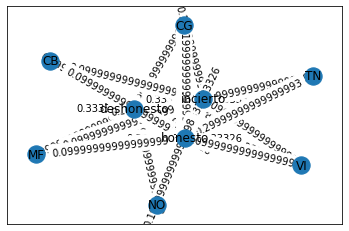

In [6]:
#Se crea el objeto gráfico.
import warnings
from matplotlib.cbook.deprecation import MatplotlibDeprecationWarning

warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)
G = nx.MultiDiGraph()

#Los nodos corresponden a los estados.
G.add_nodes_from(hidden_states)
print(f'Nodos:\n{G.nodes()}\n')

#Los bordes representan probabilidades ocultas
for k, v in hide_edges_wts.items():
    #print(k, v)
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)
    
#Los bordes representan probabilidades de emisión u observación.

for k, v in emit_edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)
    
    
print(f'Bordes:\n')
# Se imprimen las probabilidades de de transición de un estado a otro. 
for a in G.edges(data=True):
    print(a)


    
pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='neato')
nx.draw_networkx(G, pos)

#crear etiquetas  para los bordes
emit_edge_labels = {(n1,n2):d['label'] for n1,n2,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G , pos, edge_labels=emit_edge_labels)
nx.drawing.nx_pydot.write_dot(G, 'pet_dog_hidden_markov.dot')

In [50]:
#array_prueba = np.arange(18).reshape(3,6)
#print(type(b_final))
#print(type(array_prueba))
#i = 0
#j = 0
#for row in b_final:
 #   print(j)
  #  for cell in row:
   #     print(b_final[0,0])
       # print(i)
    #    array_prueba[i,j] = np.around(b_final[i,j], 2)
     #   i = i+1   
    #j = j
    


In [7]:
obs_vi = np.array([2,3,5,5,1,3,2,2,2,2,2,2,2,2,2,3,3,1,1,1,1,1,1,4,4,4,4])
array_nstates = ([])
inv_obs_map = dict((v,k) for k, v in obs_map.items())

obs_seq = [inv_obs_map[v] for v in list(obs_vi)]

print( pd.DataFrame(np.column_stack([obs_vi, obs_seq]), 
                columns=['Código', 'Secuencia']) )

   Código Secuencia
0       2        CG
1       3        MF
2       5        NO
3       5        NO
4       1        TN
5       3        MF
6       2        CG
7       2        CG
8       2        CG
9       2        CG
10      2        CG
11      2        CG
12      2        CG
13      2        CG
14      2        CG
15      3        MF
16      3        MF
17      1        TN
18      1        TN
19      1        TN
20      1        TN
21      1        TN
22      1        TN
23      4        VI
24      4        VI
25      4        VI
26      4        VI


In [8]:
def viterbi(pi, a, b, obs):
    
    nStates = np.shape(b)[0]
    T = np.shape(obs)[0]
   
    # Camino inicial. Matrices con ceros.
    path = np.zeros(T)
    # delta --> mayor probabilidad de cualquier camino que alcance el estado i.
    delta = np.zeros((nStates, T))
    # phi --> argmax por paso de tiempo para cada estado
    phi = np.zeros((nStates, T))
    
    # inicio
    delta[:, 0] = pi * b[:, obs[0]]
    phi[:, 0] = 0

    print('\nInicio. Caminar hacia adelante\n')    
    # Extensión del algoritmo directo
    for t in range(1, T):
        for s in range(nStates):
                
            delta[s, t] = np.max(delta[:, t-1] * a[:, s]) * b[s, obs[t]] 
            phi[s, t] = np.argmax(delta[:, t-1] * a[:, s])
            print('s={s} and t={t}: phi[{s}, {t}] = {phi}'.format(s=s, t=t, phi=phi[s, t]))
    
    # Encontrar el camino óptimo
    print('-'*50)
    print('Iniciar retroceso\n')
    path[T-1] = np.argmax(delta[:, T-1])
    
    
    for t in range(T-2, -1, -1):
        
        x = int(path[t+1])
    
        path[t] = phi[x, [t+1]]
        print('path[{}] = {}'.format(t, path[t]))
        
    return path, delta, phi

print(pi)
print(a_final)
path, delta, phi = viterbi(pi, a_final, b_final, obs_vi)
print('\n La mejor ruta del estado: \n', path)
print('\n delta:\n', delta)
print('phi:\n', phi)


[0.33333333 0.33333333 0.33333333]
[[0.33333333333333326 0.33333333333333326 0.33333333333333326]
 [0.33333333333333326 0.33333333333333326 0.33333333333333326]
 [0.33333333333333326 0.33333333333333326 0.33333333333333326]]

Inicio. Caminar hacia adelante

s=0 and t=1: phi[0, 1] = 0.0
s=1 and t=1: phi[1, 1] = 0.0
s=2 and t=1: phi[2, 1] = 0.0
s=0 and t=2: phi[0, 2] = 0.0
s=1 and t=2: phi[1, 2] = 0.0
s=2 and t=2: phi[2, 2] = 0.0
s=0 and t=3: phi[0, 3] = 0.0
s=1 and t=3: phi[1, 3] = 0.0
s=2 and t=3: phi[2, 3] = 0.0
s=0 and t=4: phi[0, 4] = 0.0
s=1 and t=4: phi[1, 4] = 0.0
s=2 and t=4: phi[2, 4] = 0.0
s=0 and t=5: phi[0, 5] = 0.0
s=1 and t=5: phi[1, 5] = 0.0
s=2 and t=5: phi[2, 5] = 0.0
s=0 and t=6: phi[0, 6] = 0.0
s=1 and t=6: phi[1, 6] = 0.0
s=2 and t=6: phi[2, 6] = 0.0
s=0 and t=7: phi[0, 7] = 0.0
s=1 and t=7: phi[1, 7] = 0.0
s=2 and t=7: phi[2, 7] = 0.0
s=0 and t=8: phi[0, 8] = 0.0
s=1 and t=8: phi[1, 8] = 0.0
s=2 and t=8: phi[2, 8] = 0.0
s=0 and t=9: phi[0, 9] = 0.0
s=1 and t=9: phi[

In [9]:
state_map = {0:'deshonesto', 1:'incierto', 2:'honesto'}
state_path = [state_map[v] for v in path]

(pd.DataFrame()
 .assign(Observación=obs_seq)
 .assign(Mejor_Camino=state_path))

,Observación,Mejor_Camino
0,CG,deshonesto
1,MF,deshonesto
2,NO,deshonesto
3,NO,deshonesto
4,TN,deshonesto
5,MF,deshonesto
6,CG,deshonesto
7,CG,deshonesto
8,CG,deshonesto
9,CG,deshonesto
